In [1]:
%matplotlib inline
import numpy as np

import plotting
import sampling

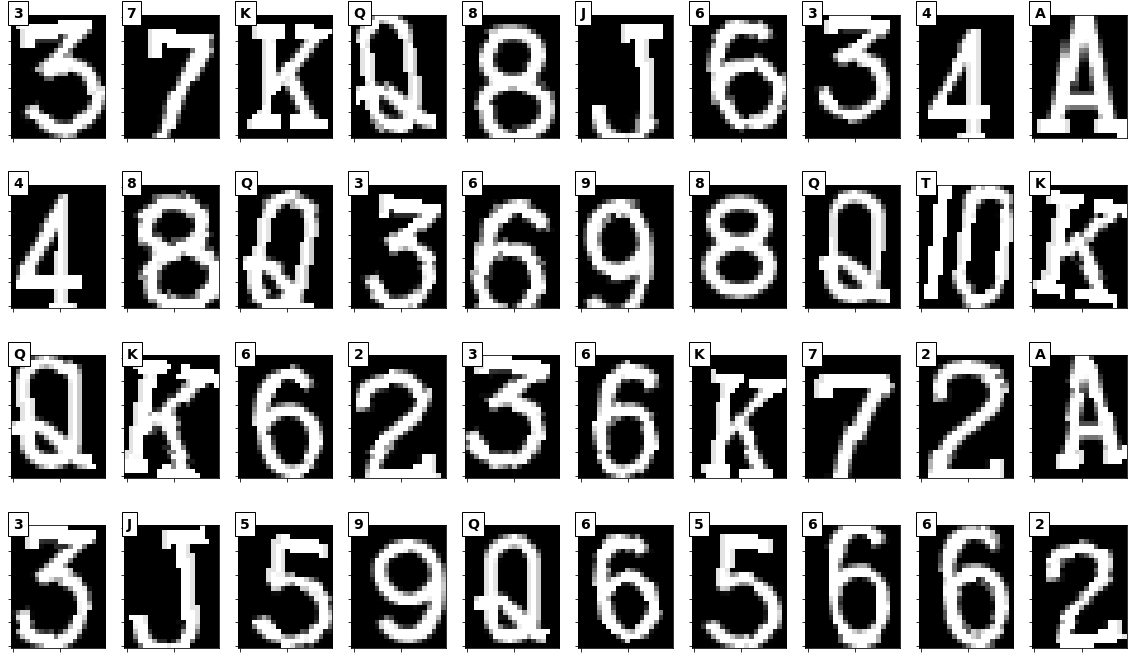

In [2]:
samples = sampling.Samples('res/cards/rank')
X, y = samples.next_batch(1000)

images = X[:40]
labels = list(map(lambda l: samples.vocabulary[l], y[:40].argmax(axis=1)))

plotting.stack_images(images, labels, num_cols=10, num_rows=4)